# Import Necessary libs

In [1]:
import pyspark
from pyspark.sql import SparkSession
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Load data

Load using pyspark

In [2]:
DATA_PATH = 'C:/Users/ALike/Documents/Academic/2021-2022/SD201/FinalProject/Twitter_Analysis/Data/covid_data/'
FILE_NAME = 'hydrated_tweets'

spark = SparkSession.builder.getOrCreate()

In [3]:
df = spark.read.json(DATA_PATH + 'hydrated_tweets')

# Initial Feature Selection

In this step we will select the meaningful features from our dataset. There nested json structures in our dataset; So, we will look at the dataset schema then try to manually select features.

In [4]:
df.printSchema()

root
 |-- contributors: string (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true

As you can see our dataset contains a lot of features which investigating some of them can be tricky and time-consuming. It is also interesting to mention that some of them are just replicas. So, here we will try to select a variety of them:

In [5]:
cols = [ "contributors"              # String:  
        ,"coordinates.coordinates"   # Array of float: The longitude and latitude of the Tweet’s location, as a collection in the form [longitude, latitude]
        ,"coordinates.type"          # String: The type of data encoded in the coordinates property. This will be “Point” for Tweet coordinates fields.
        ,"geo.Coordinates"
        ,"Created_at"                # String: UTC time when this Tweet was created.
        ,"entities.hashtags.Text"         # Arrays of Hashtags containing an object for every hashtag included in the Tweet body, and include an empty array if no hashtags are present
        ,"entities.urls.Url"             # Arrays of urls containing an object for every link included in the Tweet body, and include an empty array if no links are present.
        ,"entities.user_mentions.id_stR"    # Arrays of UserMentions containing an object for every user mention included in the Tweet body, and include an empty array if no user mention is present.
        ,"favorite_count"            # Integer: Indicates approximately how many times this Tweet has been liked by Twitter users.
        ,"favorited"                 # Boolean: Indicates whether this Tweet has been liked by the authenticating user.
        ,"id_str"                    # String: The string representation of the unique identifier for this Tweet. Implementations should use this rather than the large integer in id.
        ,"text"                      # String: The actual UTF-8 text of the status update. See twitter-text (https://github.com/twitter/twitter-text/blob/master/rb/lib/twitter-text/regex.rb) for details on what characters are currently considered valid.
        ,"in_reply_to_status_id_str" # String: If the represented Tweet is a reply, this field will contain the string representation of the original Tweet’s ID
        ,"in_reply_to_user_id_str"   # String: If the represented Tweet is a reply, this field will contain the string representation of the original Tweet’s author ID. This will not necessarily always be the user directly mentioned in the Tweet.
        ,"in_reply_to_screen_name"   # String: If the represented Tweet is a reply, this field will contain the screen name of the original Tweet’s author. 
        ,"is_quote_status"           # Boolean: Indicates whether this is a Quoted Tweet.
        ,"lang"                      # String: When present, indicates a BCP 47 language identifier corresponding to the machine-detected language of the Tweet text, or und if no language could be detected.
        ,"place.iD"                  # String: ID representing this place. Note that this is represented as a string, not an integer.
        ,"place.country_code"        # String: Shortened country code representing the country containing this place. Ex: "US"
        ,"place.country"             # String: Name of the country containing this place. Ex: "United States"
        ,"place.place_type"          # String: The type of location represented by this place. Example: "place_type":"city"
        ,"place.full_name"           # String: Full human-readable representation of the place’s name.
        ,"possibly_sensitive"        # Boolean: This field only surfaces when a Tweet contains a link. The meaning of the field doesn’t pertain to the Tweet content itself, but instead it is an indicator that the URL contained in the Tweet may contain content or media identified as sensitive content.
        ,"quoted_status_id_str"      # String: This field only surfaces when the Tweet is a quote Tweet. This is the string representation Tweet ID of the quoted Tweet. 
        ,"source"                    # String: Utility used to post the Tweet, as an HTML-formatted string. Tweets from the Twitter website have a source value of web.
        ,"retweet_count"             # Integer: Number of times this Tweet has been retweeted. 
        ,"retweeted"                 # Boolean: Indicates whether this Tweet has been Retweeted by the authenticating user.     
        ,"withheld_in_countries"     # Arrays of String: When present, indicates a list of uppercase two-letter country codes this content is withheld from. 
        ,"user.id"                   # long: The string representation of the unique identifier for this User. Implementations should use this rather than the large, possibly un-consumable integer in id.
        ,"user.name"                 # String: The name of the user, as they’ve defined it. Not necessarily a person’s name. Typically capped at 50 characters, but subject to change. 
        ,"user.screen_name"          # String: The screen name, handle, or alias that this user identifies themselves with. screen_names are unique but subject to change. Use id_str as a user identifier whenever possible. Typically a maximum of 15 characters long, but some historical accounts may exist with longer names.
        ,"user.location"             # String: the user-defined location for this account’s profile. Not necessarily a location, nor machine-parseable. This field will occasionally be fuzzily interpreted by the Search service.
        ,"user.url"                  # String: A URL provided by the user in association with their profile.
        ,"user.description"          # String: The user-defined UTF-8 string describing their account.
        ,"user.protected"            # Boolean: When true, indicates that this user has chosen to protect their Tweets.
        ,"user.verified"             # Boolean: When true, indicates that the user has a verified account. 
        ,"user.followers_count"      # Integer: The number of followers this account currently has. Under certain conditions of duress, this field will temporarily indicate “0”.
        ,"user.friends_count"        # Integer: The number of users this account is following (AKA their “followings”). Under certain conditions of duress, this field will temporarily indicate “0”.
        ,"user.listed_count"         # Integer: The number of public lists that this user is a member of.
        ,"user.favourites_count"     # Integer: The number of Tweets this user has liked in the account’s lifetime. British spelling used in the field name for historical reasons. 
        ,"user.statuses_count"       # Integer: The number of Tweets (including retweets) issued by the user. 
        ,"user.created_at"           # String: The UTC datetime that the user account was created on Twitter.
        ,"user.default_profile"      # Boolean: When true, indicates that the user has not altered the theme or background of their user profile.
        ,"user.default_profile_image"# Boolean: When true, indicates that the user has not uploaded their own profile image and a default image is used instead. 
       ]

In [6]:
feature_number = len(cols)
print("There " + str(len(cols)) + " features/columns in our dataset!")

There 44 features/columns in our dataset!


We manualy selected {{ 44 }} meaningful features to work with 

In [7]:
cleaned_DF = df.select(*cols).toPandas()
print(cleaned_DF.shape)
cleaned_DF.head(2)

(172414, 44)


,contributors,coordinates,type,Coordinates,Created_at,Text,Url,id_stR,favorite_count,favorited,...,protected,verified,followers_count,friends_count,listed_count,favourites_count,statuses_count,created_at,default_profile,default_profile_image
0,None,None,None,None,Wed Jan 20 05:04:59 +0000 2021,[],[https://t.co/HnOoSmtqUq],[],0,False,...,False,False,125,141,0,44,272830,Tue Jul 31 17:55:29 +0000 2012,False,False
1,None,None,None,None,Wed Jan 20 05:04:27 +0000 2021,[],[https://t.co/JZTGmx5sxZ],[1652541],0,False,...,False,False,439,480,0,14753,12736,Sat Nov 07 15:23:33 +0000 2020,True,False


In [8]:
cleaned_DF = cleaned_DF.rename(columns={ 'Created_at': 'tweet_created_at'
                      ,'Text': 'hashtag_arrays'
                      ,'Coordinates': 'GeoCoordinates'
                      ,'Url': 'urls_array'
                      ,'iD': 'place_id'
                      ,'id_stR': 'user_mentions_arrays'
                      ,'created_at': 'user_created_at'
                      ,'id_str': 'tweet_id'
                      ,'id': 'user_id'})

In [9]:
cleaned_DF.columns

Index(['contributors', 'coordinates', 'type', 'GeoCoordinates',
       'tweet_created_at', 'hashtag_arrays', 'urls_array',
       'user_mentions_arrays', 'favorite_count', 'favorited', 'tweet_id',
       'text', 'in_reply_to_status_id_str', 'in_reply_to_user_id_str',
       'in_reply_to_screen_name', 'is_quote_status', 'lang', 'place_id',
       'country_code', 'country', 'place_type', 'full_name',
       'possibly_sensitive', 'quoted_status_id_str', 'source', 'retweet_count',
       'retweeted', 'withheld_in_countries', 'user_id', 'name', 'screen_name',
       'location', 'url', 'description', 'protected', 'verified',
       'followers_count', 'friends_count', 'listed_count', 'favourites_count',
       'statuses_count', 'user_created_at', 'default_profile',
       'default_profile_image'],
      dtype='object')

In [10]:
cleaned_DF.shape

(172414, 44)

In [11]:
pd.set_option("max_columns", 50)
cleaned_DF.head(2)

,contributors,coordinates,type,GeoCoordinates,tweet_created_at,hashtag_arrays,urls_array,user_mentions_arrays,favorite_count,favorited,tweet_id,text,in_reply_to_status_id_str,in_reply_to_user_id_str,in_reply_to_screen_name,is_quote_status,lang,place_id,country_code,country,place_type,full_name,possibly_sensitive,quoted_status_id_str,source,retweet_count,retweeted,withheld_in_countries,user_id,name,screen_name,location,url,description,protected,verified,followers_count,friends_count,listed_count,favourites_count,statuses_count,user_created_at,default_profile,default_profile_image
0,None,None,None,None,Wed Jan 20 05:04:59 +0000 2021,[],[https://t.co/HnOoSmtqUq],[],0,False,1351757593035698176,More contagious UK coronavirus variant detecte...,None,None,None,False,en,None,None,None,None,None,False,None,"<a href=""https://www.iweller.com"" rel=""nofollo...",0,False,None,728894570,iWeller.com,iWeller_health,,https://t.co/bRHw1keG80,,False,False,125,141,0,44,272830,Tue Jul 31 17:55:29 +0000 2012,False,False
1,None,None,None,None,Wed Jan 20 05:04:27 +0000 2021,[],[https://t.co/JZTGmx5sxZ],[1652541],0,False,1351757459166285824,"Biden leads observance of America's 400,000 CO...",None,None,None,False,en,None,None,None,None,None,False,None,"<a href=""https://mobile.twitter.com"" rel=""nofo...",0,False,None,1325096459746807812,Patrick #JeSuisVacciné #PassSanitaire #Macron2022,Patrick43360346,,None,Double culture à la maison\nHeureux papa d'un ...,False,False,439,480,0,14753,12736,Sat Nov 07 15:23:33 +0000 2020,True,False


# Feature Creation

In this step we will use existing colmuns to generate less complicated and more clear features. EX: tweet_created_at --> day, week_day, months, hour, minute (not second! :) )

In [12]:
cleaned_DF['tweet_created_at_minute'] = pd.to_datetime(cleaned_DF['tweet_created_at']).dt.time.apply(lambda x: x.minute)
cleaned_DF['tweet_created_at_hour'] = pd.to_datetime(cleaned_DF['tweet_created_at']).dt.time.apply(lambda x: x.hour)
cleaned_DF['tweet_created_at_months'] = pd.to_datetime(cleaned_DF['tweet_created_at']).dt.date.apply(lambda x: x.month)
cleaned_DF['tweet_created_at_year'] = pd.to_datetime(cleaned_DF['tweet_created_at']).dt.date.apply(lambda x: x.year)
cleaned_DF['tweet_created_at_day'] = pd.to_datetime(cleaned_DF['tweet_created_at']).dt.date.apply(lambda x: x.day)
cleaned_DF['tweet_created_at_week_day'] = cleaned_DF['tweet_created_at'].apply(lambda x: x.split(" ")[0])

We apply the same method on User_created_at as well

In [13]:
cleaned_DF['user_created_at_minute'] = pd.to_datetime(cleaned_DF['user_created_at']).dt.time.apply(lambda x: x.minute)
cleaned_DF['user_created_at_hour'] = pd.to_datetime(cleaned_DF['user_created_at']).dt.time.apply(lambda x: x.hour)
cleaned_DF['user_created_at_months'] = pd.to_datetime(cleaned_DF['user_created_at']).dt.date.apply(lambda x: x.month)
cleaned_DF['user_created_at_year'] = pd.to_datetime(cleaned_DF['user_created_at']).dt.date.apply(lambda x: x.year)
cleaned_DF['user_created_at_day'] = pd.to_datetime(cleaned_DF['user_created_at']).dt.date.apply(lambda x: x.day)
cleaned_DF['user_created_at_week_day'] = cleaned_DF['user_created_at'].apply(lambda x: x.split(" ")[0])
cleaned_DF.head(2)

,contributors,coordinates,type,GeoCoordinates,tweet_created_at,hashtag_arrays,urls_array,user_mentions_arrays,favorite_count,favorited,tweet_id,text,in_reply_to_status_id_str,in_reply_to_user_id_str,in_reply_to_screen_name,is_quote_status,lang,place_id,country_code,country,place_type,full_name,possibly_sensitive,quoted_status_id_str,source,...,location,url,description,protected,verified,followers_count,friends_count,listed_count,favourites_count,statuses_count,user_created_at,default_profile,default_profile_image,tweet_created_at_minute,tweet_created_at_hour,tweet_created_at_months,tweet_created_at_year,tweet_created_at_day,tweet_created_at_week_day,user_created_at_minute,user_created_at_hour,user_created_at_months,user_created_at_year,user_created_at_day,user_created_at_week_day
0,None,None,None,None,Wed Jan 20 05:04:59 +0000 2021,[],[https://t.co/HnOoSmtqUq],[],0,False,1351757593035698176,More contagious UK coronavirus variant detecte...,None,None,None,False,en,None,None,None,None,None,False,None,"<a href=""https://www.iweller.com"" rel=""nofollo...",...,,https://t.co/bRHw1keG80,,False,False,125,141,0,44,272830,Tue Jul 31 17:55:29 +0000 2012,False,False,4,5,1,2021,20,Wed,55,17,7,2012,31,Tue
1,None,None,None,None,Wed Jan 20 05:04:27 +0000 2021,[],[https://t.co/JZTGmx5sxZ],[1652541],0,False,1351757459166285824,"Biden leads observance of America's 400,000 CO...",None,None,None,False,en,None,None,None,None,None,False,None,"<a href=""https://mobile.twitter.com"" rel=""nofo...",...,,None,Double culture à la maison\nHeureux papa d'un ...,False,False,439,480,0,14753,12736,Sat Nov 07 15:23:33 +0000 2020,True,False,4,5,1,2021,20,Wed,23,15,11,2020,7,Sat


# Feature Transfer

First, We convert all the boolean features to 0-1 values instead of True/False

Boolean Columns --> Favorited, is_quote_status, retweeted, protected, verified, default_profile, default_profile_image

In [14]:
boolean_cols = ['favorited', 'is_quote_status', 'retweeted', 'protected', 'verified', 'default_profile', 'default_profile_image']

In [15]:
for col in boolean_cols:
    cleaned_DF[col] = cleaned_DF[col].astype(int)
cleaned_DF.head(2)

,contributors,coordinates,type,GeoCoordinates,tweet_created_at,hashtag_arrays,urls_array,user_mentions_arrays,favorite_count,favorited,tweet_id,text,in_reply_to_status_id_str,in_reply_to_user_id_str,in_reply_to_screen_name,is_quote_status,lang,place_id,country_code,country,place_type,full_name,possibly_sensitive,quoted_status_id_str,source,...,location,url,description,protected,verified,followers_count,friends_count,listed_count,favourites_count,statuses_count,user_created_at,default_profile,default_profile_image,tweet_created_at_minute,tweet_created_at_hour,tweet_created_at_months,tweet_created_at_year,tweet_created_at_day,tweet_created_at_week_day,user_created_at_minute,user_created_at_hour,user_created_at_months,user_created_at_year,user_created_at_day,user_created_at_week_day
0,None,None,None,None,Wed Jan 20 05:04:59 +0000 2021,[],[https://t.co/HnOoSmtqUq],[],0,0,1351757593035698176,More contagious UK coronavirus variant detecte...,None,None,None,0,en,None,None,None,None,None,False,None,"<a href=""https://www.iweller.com"" rel=""nofollo...",...,,https://t.co/bRHw1keG80,,0,0,125,141,0,44,272830,Tue Jul 31 17:55:29 +0000 2012,0,0,4,5,1,2021,20,Wed,55,17,7,2012,31,Tue
1,None,None,None,None,Wed Jan 20 05:04:27 +0000 2021,[],[https://t.co/JZTGmx5sxZ],[1652541],0,0,1351757459166285824,"Biden leads observance of America's 400,000 CO...",None,None,None,0,en,None,None,None,None,None,False,None,"<a href=""https://mobile.twitter.com"" rel=""nofo...",...,,None,Double culture à la maison\nHeureux papa d'un ...,0,0,439,480,0,14753,12736,Sat Nov 07 15:23:33 +0000 2020,1,0,4,5,1,2021,20,Wed,23,15,11,2020,7,Sat


Second, we convert all the categorical data to numerical values
Categorical columns --> filter_level, lang, tweet_created_at_week_day, user_created_at_week_day

In [16]:
cat_cols_1 = ['lang']
cat_cols_2 = ['tweet_created_at_week_day', 'user_created_at_week_day']

lang_le = LabelEncoder()
lang_col_encoded = lang_le.fit_transform(cleaned_DF[cat_cols_1[0]])
cleaned_DF[cat_cols_1[0]] = lang_col_encoded
# Code to reverse encoding categorical data
# cleaned_DF[cat_cols_1[0]] = lang_le.inverse_transform(cleaned_DF[cat_cols_1[0]])

weekday_le = LabelEncoder()
weekday_col_encoded = weekday_le.fit_transform(cleaned_DF[cat_cols_2[0]])
cleaned_DF[cat_cols_2[0]] = weekday_col_encoded
cleaned_DF[cat_cols_2[1]] = weekday_col_encoded
# Code to reverse encoding categorical data
# cleaned_DF[cat_cols_2[0]] = weekday_le.inverse_transform(cleaned_DF[cat_col_2[0]])
# cleaned_DF[cat_cols_2[1] = weekday_le.inverse_transform(cleaned_DF[cat_col_2[1]])

cat_col_3 = ['country_code']
country_code_le = LabelEncoder()
country_code_col_encoded = country_code_le.fit_transform(cleaned_DF[cat_col_3[0]])
cleaned_DF[cat_col_3[0]] = country_code_col_encoded
# Code to reverse encoding categorical data
# cleaned_DF[cat_col_3[0]] = country_code_le.inverse_transform(cleaned_DF[cat_col_3[0]])

# Feature Selection

In this step, we will drop features/columns that seems useless to us (whether they don't have any info (null values or just one value for all tuples))

In [17]:
for (colname,colval) in cleaned_DF.iteritems():
    try:
        if cleaned_DF[colname].unique().shape[0] < 2:
            cleaned_DF = cleaned_DF.drop(colname, axis=1)
            print("Columns " + colname + " was deleted!")
    except TypeError:
        print("Oops!  That was a list probably. Try another way for " + colname + "...")

Columns contributors was deleted!
Oops!  That was a list probably. Try another way for coordinates...
Oops!  That was a list probably. Try another way for GeoCoordinates...
Oops!  That was a list probably. Try another way for hashtag_arrays...
Oops!  That was a list probably. Try another way for urls_array...
Oops!  That was a list probably. Try another way for user_mentions_arrays...
Columns favorited was deleted!
Columns lang was deleted!
Columns retweeted was deleted!
Oops!  That was a list probably. Try another way for withheld_in_countries...
Columns protected was deleted!
Columns tweet_created_at_months was deleted!
Columns tweet_created_at_year was deleted!


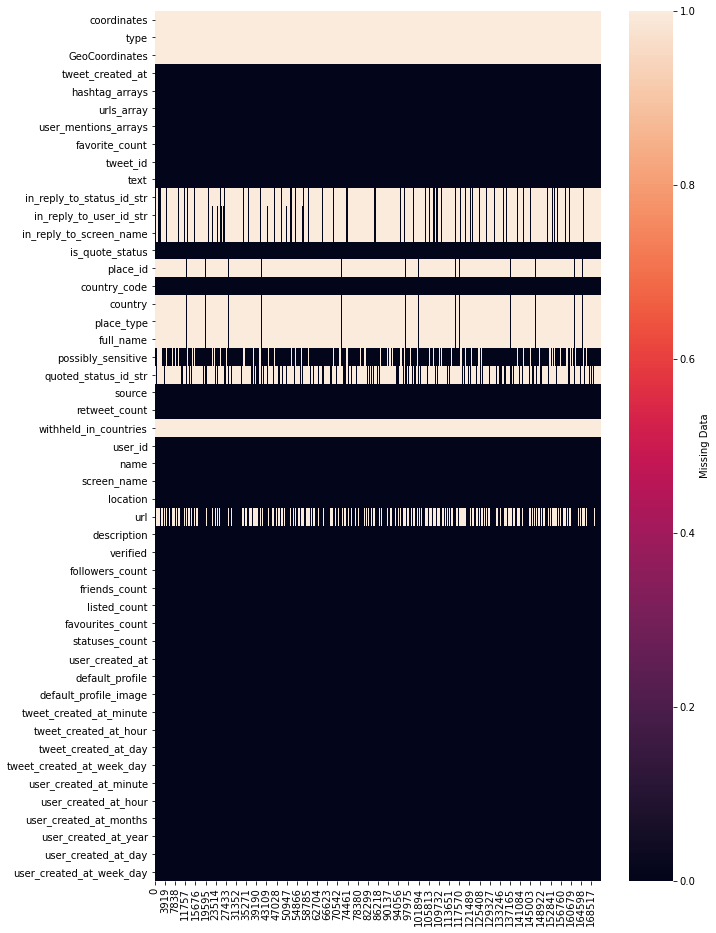

In [18]:
plt.figure(figsize=(10,16))
sns.heatmap(cleaned_DF.isna().transpose(),
            cbar_kws={'label': 'Missing Data'})
plt.savefig("visualizing_missing_data_with_heatmap_Seaborn_Python.png", dpi=100)

As you can see, there are a lot of missing values in some of our columns. In this article "https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4", the author explained when we need to drop columns or rows in case of missing values. Due to the fact that in our problem all the tweets are valid and there is no junk tweets and each of caries some type of information, we won't consider row-wise elimination. However, we will drop columns in which more than 90% of the values are missing. In further step we will do some feature selection again based on correlation and feature importance.

In [19]:
print("There are " + str(np.nonzero(cleaned_DF['retweet_count'].to_numpy())[0].shape[0]) + " non-zero retweet_count values in our dataset.") 

There are 44862 non-zero retweet_count values in our dataset.


As you can see we have deleted the Nan columns and we end up with 38 columns

In this step, we will try to drop columns that they mostly have NaN values. We dropped all columns which they have more than 90% null values. We only keep country code for Visualization purposes (Not for learning task since the missing value percentage is above 90%)

In [20]:
import numpy as np
total_number = cleaned_DF.shape[0]
print("Data Cardinality: ", total_number)
for column in cleaned_DF.columns:
    print("Column: ", column)
    null_counter = cleaned_DF[column].isna().sum()
    print("# NAN values: ", null_counter)
    null_percentage = null_counter/cleaned_DF.shape[0]
    if null_counter > 0:
        print("Null percentage: ", null_percentage)
        if null_percentage >= 0.9 and (str(column) != 'country_code'):
            cleaned_DF = cleaned_DF.drop(column, axis=1)
            print("Column " + column + " was deleted!")
    print("--------------------------------------------------------------------------")

Data Cardinality:  172414
Column:  coordinates
# NAN values:  172302
Null percentage:  0.9993504007795191
Column coordinates was deleted!
--------------------------------------------------------------------------
Column:  type
# NAN values:  172302
Null percentage:  0.9993504007795191
Column type was deleted!
--------------------------------------------------------------------------
Column:  GeoCoordinates
# NAN values:  172302
Null percentage:  0.9993504007795191
Column GeoCoordinates was deleted!
--------------------------------------------------------------------------
Column:  tweet_created_at
# NAN values:  0
--------------------------------------------------------------------------
Column:  hashtag_arrays
# NAN values:  0
--------------------------------------------------------------------------
Column:  urls_array
# NAN values:  0
--------------------------------------------------------------------------
Column:  user_mentions_arrays
# NAN values:  0
----------------------------

In [21]:
cleaned_DF.head(2)

,tweet_created_at,hashtag_arrays,urls_array,user_mentions_arrays,favorite_count,tweet_id,text,in_reply_to_status_id_str,in_reply_to_user_id_str,in_reply_to_screen_name,is_quote_status,country_code,possibly_sensitive,quoted_status_id_str,source,retweet_count,user_id,name,screen_name,location,url,description,verified,followers_count,friends_count,listed_count,favourites_count,statuses_count,user_created_at,default_profile,default_profile_image,tweet_created_at_minute,tweet_created_at_hour,tweet_created_at_day,tweet_created_at_week_day,user_created_at_minute,user_created_at_hour,user_created_at_months,user_created_at_year,user_created_at_day,user_created_at_week_day
0,Wed Jan 20 05:04:59 +0000 2021,[],[https://t.co/HnOoSmtqUq],[],0,1351757593035698176,More contagious UK coronavirus variant detecte...,None,None,None,0,111,False,None,"<a href=""https://www.iweller.com"" rel=""nofollo...",0,728894570,iWeller.com,iWeller_health,,https://t.co/bRHw1keG80,,0,125,141,0,44,272830,Tue Jul 31 17:55:29 +0000 2012,0,0,4,5,20,1,55,17,7,2012,31,1
1,Wed Jan 20 05:04:27 +0000 2021,[],[https://t.co/JZTGmx5sxZ],[1652541],0,1351757459166285824,"Biden leads observance of America's 400,000 CO...",None,None,None,0,111,False,None,"<a href=""https://mobile.twitter.com"" rel=""nofo...",0,1325096459746807812,Patrick #JeSuisVacciné #PassSanitaire #Macron2022,Patrick43360346,,None,Double culture à la maison\nHeureux papa d'un ...,0,439,480,0,14753,12736,Sat Nov 07 15:23:33 +0000 2020,1,0,4,5,20,1,23,15,11,2020,7,1


In [22]:
cleaned_DF.shape

(172414, 41)

We have created some features from tweet_created_at and user_created_at. Therefor, we will drop these two columns.

In [23]:
cleaned_DF = cleaned_DF.drop(['tweet_created_at', 'user_created_at'], axis=1)

In [24]:
cleaned_DF.info(verbose=True)
cleaned_DF.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172414 entries, 0 to 172413
Data columns (total 39 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   hashtag_arrays             172414 non-null  object
 1   urls_array                 172414 non-null  object
 2   user_mentions_arrays       172414 non-null  object
 3   favorite_count             172414 non-null  int64 
 4   tweet_id                   172414 non-null  object
 5   text                       172414 non-null  object
 6   in_reply_to_status_id_str  25743 non-null   object
 7   in_reply_to_user_id_str    29434 non-null   object
 8   in_reply_to_screen_name    29434 non-null   object
 9   is_quote_status            172414 non-null  int32 
 10  country_code               172414 non-null  int32 
 11  possibly_sensitive         140392 non-null  object
 12  quoted_status_id_str       43736 non-null   object
 13  source                     172414 non-null  

(172414, 39)

In this step. since we can not use array values for our tasks, we will convert them to numerical values

In [25]:
hashtag_temp_nonzero = []
i = 0
for index, row in cleaned_DF.iterrows():
    if (len(row['hashtag_arrays']) != 0):
        hashtag_temp_nonzero.append(len(row['hashtag_arrays']))
        i += 1
print(i)
np.unique(np.array(hashtag_temp_nonzero))

40041


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

### Dealing with array values and object features:

In [26]:
for index, row in cleaned_DF.iterrows():
    cleaned_DF["hashtag_count"] = len(row['hashtag_arrays'])
    cleaned_DF["urls_count"] = len(row['urls_array'])
    cleaned_DF["user_mentions_count"] = len(row['user_mentions_arrays'])

In [27]:
cleaned_DF = cleaned_DF.drop(['hashtag_arrays', 'urls_array', 'user_mentions_arrays'], axis=1)

In [28]:
cleaned_DF.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172414 entries, 0 to 172413
Data columns (total 39 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   favorite_count             172414 non-null  int64 
 1   tweet_id                   172414 non-null  object
 2   text                       172414 non-null  object
 3   in_reply_to_status_id_str  25743 non-null   object
 4   in_reply_to_user_id_str    29434 non-null   object
 5   in_reply_to_screen_name    29434 non-null   object
 6   is_quote_status            172414 non-null  int32 
 7   country_code               172414 non-null  int32 
 8   possibly_sensitive         140392 non-null  object
 9   quoted_status_id_str       43736 non-null   object
 10  source                     172414 non-null  object
 11  retweet_count              172414 non-null  int64 
 12  user_id                    172414 non-null  int64 
 13  name                       172414 non-null  

In [29]:
cleaned_DF.head(3)

,favorite_count,tweet_id,text,in_reply_to_status_id_str,in_reply_to_user_id_str,in_reply_to_screen_name,is_quote_status,country_code,possibly_sensitive,quoted_status_id_str,source,retweet_count,user_id,name,screen_name,location,url,description,verified,followers_count,friends_count,listed_count,favourites_count,statuses_count,default_profile,default_profile_image,tweet_created_at_minute,tweet_created_at_hour,tweet_created_at_day,tweet_created_at_week_day,user_created_at_minute,user_created_at_hour,user_created_at_months,user_created_at_year,user_created_at_day,user_created_at_week_day,hashtag_count,urls_count,user_mentions_count
0,0,1351757593035698176,More contagious UK coronavirus variant detecte...,None,None,None,0,111,False,None,"<a href=""https://www.iweller.com"" rel=""nofollo...",0,728894570,iWeller.com,iWeller_health,,https://t.co/bRHw1keG80,,0,125,141,0,44,272830,0,0,4,5,20,1,55,17,7,2012,31,1,0,1,0
1,0,1351757459166285824,"Biden leads observance of America's 400,000 CO...",None,None,None,0,111,False,None,"<a href=""https://mobile.twitter.com"" rel=""nofo...",0,1325096459746807812,Patrick #JeSuisVacciné #PassSanitaire #Macron2022,Patrick43360346,,None,Double culture à la maison\nHeureux papa d'un ...,0,439,480,0,14753,12736,1,0,4,5,20,1,23,15,11,2020,7,1,0,1,0
2,0,1351757551814258688,WORKING smoke alarms save lives! Check yours ...,None,None,None,1,111,False,1351601290997018625,"<a href=""https://mobile.twitter.com"" rel=""nofo...",1,2382122324,Jim Resnick,ResnickJames,,None,"Proud American, Lifelong Fire Safety Educator ...",0,80,57,0,1636,448,1,0,4,5,20,1,9,13,3,2014,10,1,0,1,0


In [30]:
cleaned_DF = cleaned_DF.drop(['source', 'url'], axis=1)
cleaned_DF.head(3)

,favorite_count,tweet_id,text,in_reply_to_status_id_str,in_reply_to_user_id_str,in_reply_to_screen_name,is_quote_status,country_code,possibly_sensitive,quoted_status_id_str,retweet_count,user_id,name,screen_name,location,description,verified,followers_count,friends_count,listed_count,favourites_count,statuses_count,default_profile,default_profile_image,tweet_created_at_minute,tweet_created_at_hour,tweet_created_at_day,tweet_created_at_week_day,user_created_at_minute,user_created_at_hour,user_created_at_months,user_created_at_year,user_created_at_day,user_created_at_week_day,hashtag_count,urls_count,user_mentions_count
0,0,1351757593035698176,More contagious UK coronavirus variant detecte...,None,None,None,0,111,False,None,0,728894570,iWeller.com,iWeller_health,,,0,125,141,0,44,272830,0,0,4,5,20,1,55,17,7,2012,31,1,0,1,0
1,0,1351757459166285824,"Biden leads observance of America's 400,000 CO...",None,None,None,0,111,False,None,0,1325096459746807812,Patrick #JeSuisVacciné #PassSanitaire #Macron2022,Patrick43360346,,Double culture à la maison\nHeureux papa d'un ...,0,439,480,0,14753,12736,1,0,4,5,20,1,23,15,11,2020,7,1,0,1,0
2,0,1351757551814258688,WORKING smoke alarms save lives! Check yours ...,None,None,None,1,111,False,1351601290997018625,1,2382122324,Jim Resnick,ResnickJames,,"Proud American, Lifelong Fire Safety Educator ...",0,80,57,0,1636,448,1,0,4,5,20,1,9,13,3,2014,10,1,0,1,0


In [31]:
cleaned_DF.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172414 entries, 0 to 172413
Data columns (total 37 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   favorite_count             172414 non-null  int64 
 1   tweet_id                   172414 non-null  object
 2   text                       172414 non-null  object
 3   in_reply_to_status_id_str  25743 non-null   object
 4   in_reply_to_user_id_str    29434 non-null   object
 5   in_reply_to_screen_name    29434 non-null   object
 6   is_quote_status            172414 non-null  int32 
 7   country_code               172414 non-null  int32 
 8   possibly_sensitive         140392 non-null  object
 9   quoted_status_id_str       43736 non-null   object
 10  retweet_count              172414 non-null  int64 
 11  user_id                    172414 non-null  int64 
 12  name                       172414 non-null  object
 13  screen_name                172414 non-null  

Since the maximum length of hashtag arrays are 12, we will break down the hashtag arrays and split them into 12 new features plus we will create a new feature named hashtag_count as well

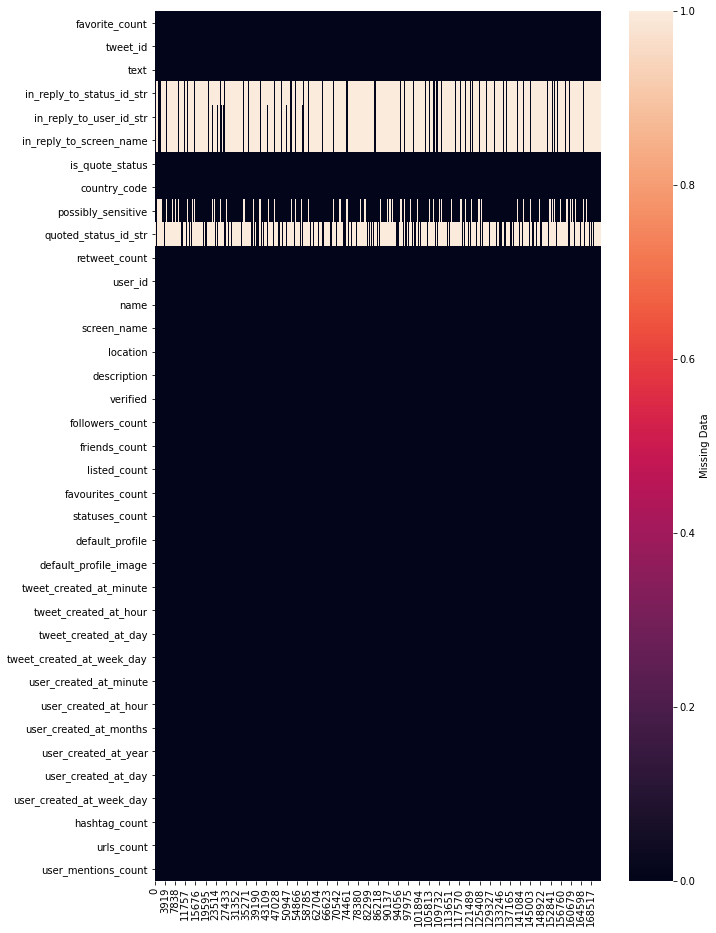

In [32]:
plt.figure(figsize=(10,16))
sns.heatmap(cleaned_DF.isna().transpose(),
            cbar_kws={'label': 'Missing Data'})
plt.savefig("visualizing_missing_data_with_heatmap_Seaborn_Python.png", dpi=100)

In [33]:
cleaned_DF.head(3)

,favorite_count,tweet_id,text,in_reply_to_status_id_str,in_reply_to_user_id_str,in_reply_to_screen_name,is_quote_status,country_code,possibly_sensitive,quoted_status_id_str,retweet_count,user_id,name,screen_name,location,description,verified,followers_count,friends_count,listed_count,favourites_count,statuses_count,default_profile,default_profile_image,tweet_created_at_minute,tweet_created_at_hour,tweet_created_at_day,tweet_created_at_week_day,user_created_at_minute,user_created_at_hour,user_created_at_months,user_created_at_year,user_created_at_day,user_created_at_week_day,hashtag_count,urls_count,user_mentions_count
0,0,1351757593035698176,More contagious UK coronavirus variant detecte...,None,None,None,0,111,False,None,0,728894570,iWeller.com,iWeller_health,,,0,125,141,0,44,272830,0,0,4,5,20,1,55,17,7,2012,31,1,0,1,0
1,0,1351757459166285824,"Biden leads observance of America's 400,000 CO...",None,None,None,0,111,False,None,0,1325096459746807812,Patrick #JeSuisVacciné #PassSanitaire #Macron2022,Patrick43360346,,Double culture à la maison\nHeureux papa d'un ...,0,439,480,0,14753,12736,1,0,4,5,20,1,23,15,11,2020,7,1,0,1,0
2,0,1351757551814258688,WORKING smoke alarms save lives! Check yours ...,None,None,None,1,111,False,1351601290997018625,1,2382122324,Jim Resnick,ResnickJames,,"Proud American, Lifelong Fire Safety Educator ...",0,80,57,0,1636,448,1,0,4,5,20,1,9,13,3,2014,10,1,0,1,0


In [34]:
cleaned_DF.shape

(172414, 37)

In [ ]:
cleaned_DF.to_csv('step1_output.csv')